# Underfitting, Overfitting and Regularization in ML

## Intro

<br /><br />

### Motivation

There are quite a few Machine Learning algorithms out there and we need the one that best suits the problem we are trying to solve. 

The most important criteria one should consider while selecting a model is its <b>generalization ability</b> or, more formally, an <b>Expected Test Error</b>. Model generalization ability means how well does the model perform on <b>unseen data</b> (i.e outside the training set) when faced real world.

Imagine our task is to say whether or not there is a dog depicted on the picture. Also, let's assume our train dataset cotains limited number of dog breeds. Example of a model with good generalization ability would be a one that performs accurately even on the pictures with dog breeds that never occured in train set.

Recently, Google's model misclassified black people as gorillas, which is one of the many examples of models failing in real-world:

<img src='images/ml_regularization/nn_fail.png' />

Throughout the class, we will go through techniques for estimating and improving model generalizability. Theory will be backed up by examples in Python and Scikit-Learn.


### Learning Objectives

At the end of this class, listeners will be able to:

<ul>
    <li>Understand concepts related to model generalization such as overfitting, underfitting and bias-variance trade-off.</li>
    <li>Techniques to improve generalization by regularization.</li>
    <li>Apply regularization to linear and logistic regression.</li>
    <li>Use Scikit-Learn library for simple tasks.</li>
</ul>

### Reading Material

https://web.stanford.edu/~hastie/Papers/ESLII.pdf The Elements of Statistical Learning, section 7.<br />
https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff<br />
https://scikit-learn.org/stable/modules/linear_model.html#lasso
<br /><br />

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

## Underfitting and Overfitting

Below is an intuitive example-by-example explanation of the two essential concepts in Machine Learning: <b>Underfitting</b> and <b>Overfitting</b>.

In below examples, we are going to use toy linear regression problem. 

We are going to predict a <b>land price</b> (for simplicity, suppose its quadratic, i.e X by X square meters) given the <b>length of its side</b> (in meters).

For simplicity, we are going to use synthetic (not real) data. We assume that true dependence between the length of land's side and its price is given by parabola: $f(x)=a*x^2+b*x+c, x>0$ where $x$ is length and $f(x)$ is price.

We also assume that our observations are <b>noisy</b> and we simulate this noise by adding centered Gaussian to our parabola.

Let's generate some data for illustrations...

In [2]:
A, B, C = 3.7, 0.1, 2.1 # True parabola parameters

In [3]:
def generate_training_set(a, b, c, size: int, eps: float=2):
    
    # define quadratic function of form f(x)=A*X^2+B*X+C
    f = lambda x: a*x**2 + b*x + c
    
    # define X axis
    x = np.linspace(0.1, 10, num=size)
    
    # define Y axis
    y = [f(i) for i in x]
    
    # generate random Gaussian noise
    e = np.random.normal(0, eps, size=(size))
    
    return np.array(x), np.array(y), e

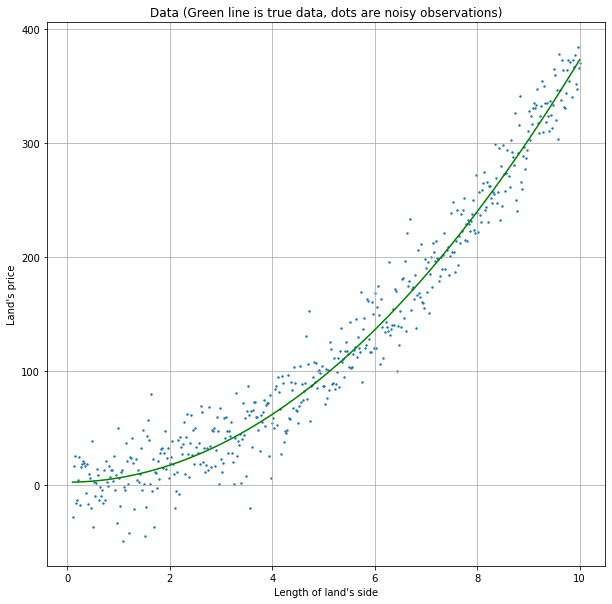

In [4]:
# plot the dataset (each run will plot different dataset from the same distribution/data generating process)

X, Y, e = generate_training_set(A, B, C, size=500, eps=20)

plt.figure(figsize=(10, 10))
plt.scatter(X, Y + e, s=2)
plt.plot(X, Y, 'g')
plt.xlabel("Length of land's side")
plt.ylabel("Land's price")
plt.title('Data (Green line is true data, dots are noisy observations)')
plt.grid()

Let's fit the above data using just $x$ (Length of land's side) as a single feature:

Our model will be $\hat{f}(x)=w_0 + w_1 * x$<br /><br />
Or, in vector notation: $\hat{f}(x)=dot([w_0, w_1],[1, x])$

In [5]:
# defining linear regression model (fit_intercept=False means disabling bias term)

model = LinearRegression(fit_intercept=False)

In [6]:
X, Y_true, e = generate_training_set(A, B, C, size=20, eps=20)

Y = Y_true + e # creating noisy observations by adding noise

In [7]:
# adding dummy column for bias

X1 = np.c_[np.ones(X.shape[0]), X]
X1[0:5], Y[0:5]

(array([[1.        , 0.1       ],
        [1.        , 0.62105263],
        [1.        , 1.14210526],
        [1.        , 1.66315789],
        [1.        , 2.18421053]]),
 array([-3.5929933 ,  5.33746993,  9.11910208, 52.50072446, 11.43802777]))

In [8]:
model.fit(X1, Y) # fitting the model using OLS
model.coef_ # displaying learned weights: w_0 and w_1

array([-50.42606355,  35.26037127])

In [9]:
y_pred = model.predict(X1) # generating predictions

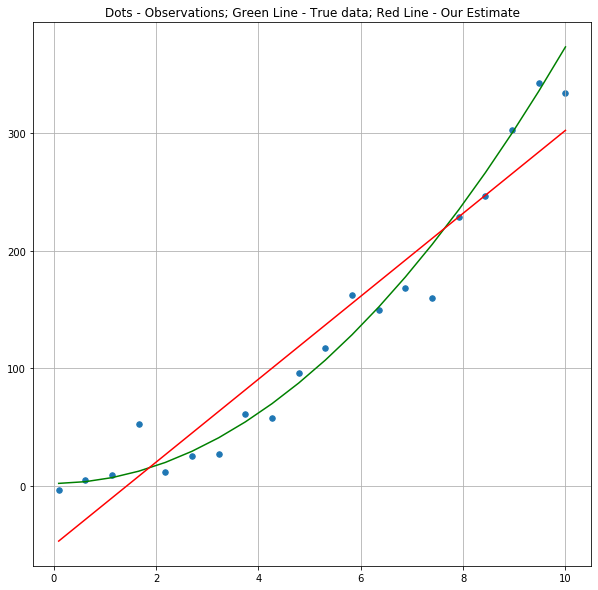

In [10]:
# plotting learned model 

plt.figure(figsize=(10, 10))
plt.scatter(X, Y, s=30)
plt.plot(X, Y_true, 'g')
plt.plot(X, y_pred, 'r')
plt.title('Dots - Observations; Green Line - True data; Red Line - Our Estimate')
plt.grid()

<b><u>Question:</u></b> Is it a good fit? Bad fit? Why?

Obviously, previous model is too simple and doesn't have enough "power" to capture quadratic dependence. Mathematically speaking, linear function isn't able to approximate quadratic one. To mitigate this, we introduce additional features to help model. 

We gonna use <b>polynomial features</b> up to 10-th degree and our model will be:<br />

$\hat{f}(x)=w_0 + w_1 * x + w_2 * x^2 + w_3 * x^3 + w_4 * x^4 + w_5 * x^5 + w_6 * x^6 + w_7 * x^7 + w_8 * x^8 + w_9 * x^9 + w_10 * x^{10}$

<b>Important Note: </b>Despite the fact that we add polynomial features, model stays linear because linearity is relative to weights and not features.

We are going to use Scikit-Learn's helper class for generating new features: 

`from sklearn.preprocessing import PolynomialFeatures`

In [11]:
# let's first define this helper class

poly = PolynomialFeatures(degree=10, include_bias=True)

# let's create features...

X2 = poly.fit_transform(X.reshape(-1, 1))

X2[:2]

array([[1.00000000e+00, 1.00000000e-01, 1.00000000e-02, 1.00000000e-03,
        1.00000000e-04, 1.00000000e-05, 1.00000000e-06, 1.00000000e-07,
        1.00000000e-08, 1.00000000e-09, 1.00000000e-10],
       [1.00000000e+00, 6.21052632e-01, 3.85706371e-01, 2.39543957e-01,
        1.48769405e-01, 9.23936303e-02, 5.73813073e-02, 3.56368119e-02,
        2.21323358e-02, 1.37453454e-02, 8.53658293e-03]])

In [12]:
model = LinearRegression(fit_intercept=False) 

model.fit(X2, Y) # fitting again with new feature set
model.coef_

array([ 3.01831293e+00, -8.16176536e+01,  2.09561692e+02, -1.64989376e+02,
        6.29676219e+01, -1.36974221e+01,  1.95568287e+00, -2.09062829e-01,
        1.70930113e-02, -9.00262616e-04,  2.11153409e-05])

In [13]:
y_pred = model.predict(X2)

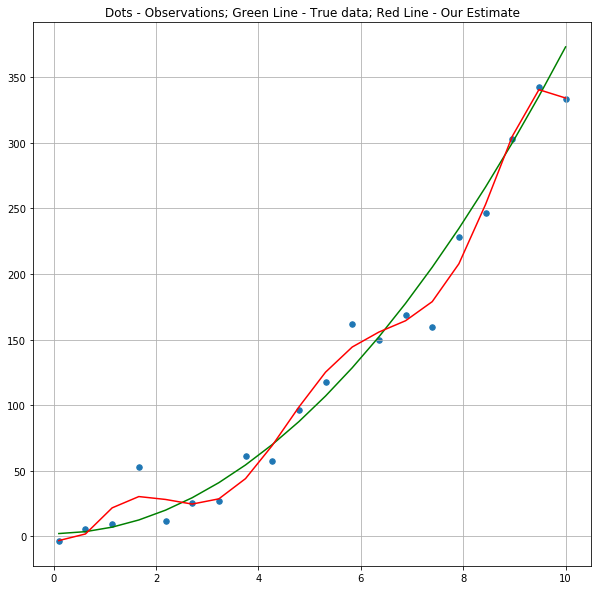

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y, s=30)
plt.plot(X, Y_true, 'g')
plt.plot(X, y_pred, 'r')
plt.title('Dots - Observations; Green Line - True data; Red Line - Our Estimate')
plt.grid()

<b><u>Question:</u></b> Is it a good fit? Bad fit? Why?<br />
<i>Hint: Generate several samples and fit the same model on them. What can you observe?</i>

<b>Some Observations...</b>
    
<ul>
    <li>Very <b>simple</b>  models have poor performance due to lack of expressive power to learn data distribution.</li>
    <li>Very <b>complex</b> models have poor performance due to excessive expressive power leading to fitting <b>noise</b> instead of the real data.</li>
</ul>
    
The first one is called <b>Underfitting</b> and the second one - <b>Overfitting</b>

In above example, first simple model <b>underfitted</b> our data, whereas, the second complex one - <b>overfitted</b>.

<i>Famous rumor about US Army's enemy tank detection algorithm.

Once upon a time, the US Army wanted to use neural networks to automatically detect camouflaged enemy tanks. They trained a model on 50 pictures with tanks and 50 - without. They tested the model and it was fine, so decided to send the model to Pentagon. After some time they got reply saying that the model was terrible. 

As it occurred, all of 50 photos with tanks were taken in cloudy day, whereas, photos without tanks were taken in sunny days. The model learned to say "yes" whenever it detected a cloud. So the model fitted noise instead of real data (tanks).</i>

## Bias-Variance Trade-Off


We will continue with our toy example...

When talking about model generalization ability, one of the important questions to ask is the following:

When training our model on <b>different training sets</b> (drawn from the <b>same</b> underlying data distribution, parabola in our case), what is our model's <b>expected prediction</b> for arbitrary fixed data point <b>$X=x_0$</b> (also drawn from underlying data distribution)?

Arguably, same model trained on different datasets will produce different predictions for same fixed $x_0$. The question is, how can we <b>quantify</b> the <b>amount of fluctuations</b> of prediction around it's true value on different datasets?

Very informally, the concepts of model's <b>bias</b> and model's <b>variance</b> can be described using the below picture of playing darts.<br />

For our fixed $x_0$, let center of the disk be a true prediction, i.e $f(x_0)$, and different shots represent model's predictions $\hat{f}(x_0)$ where each time the model has been trained on different training set (sampled from underlying data distribution).<br ><br />

<b>Low Bias</b> and <b>low Variance</b> is best case scenario;<br />
<b>High Bias</b> and <b>high Variance</b> is the worst case scenario;

<br /><br />
    
<img src='images/ml_regularization/bias-variance.png' />

Below is some code illustrating the same concepts...

In [15]:
def fit_and_predict(x, use_first_model=True):
    """This function generates training data from our initial toy distribution, trains a model (either first or 
    second one from above section) and generates a prediction for given single data point X.    
    
    Returns true value and model's estimate
    """

    X, Y_true, e = generate_training_set(A, B, C, size=20, eps=20)

    Y = Y_true + e # creating noisy observations by adding Gaussian noise (this is our train data)
    
    poly = PolynomialFeatures(degree=(1 if use_first_model else 10), include_bias=True)
    
    # augmenting training data with polynomial features
    X1 = poly.fit_transform(X.reshape(-1, 1))

    model = LinearRegression(fit_intercept=False) 

    model.fit(X1, Y) # fitting the model using OLS
    
    return A*x**2 + B*x + C, model.predict(poly.fit_transform([[x]]))[0]

True Value:  95.1
Average Estimate:  129.39718347184694
Bias:  -34.29718347184695
Variance:  21.8838736668751


/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


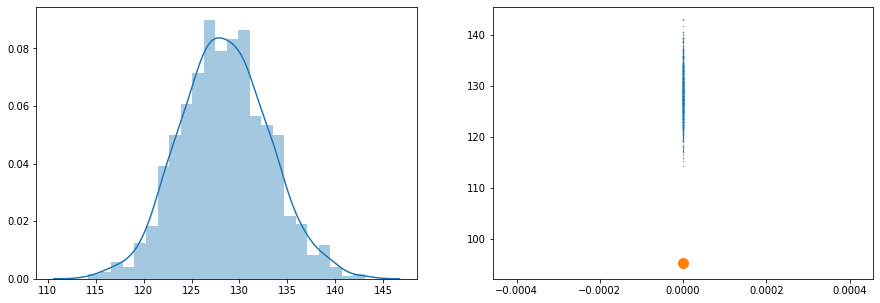

In [16]:
# here we train model on different datasets and calculate expected prediction and it's fluctuation (variance).

N = 1000 # we train model on N different datasets in total.

x0 = 5 # this is our fixed data point on which we will measure prediction quality and fluctuations.

use_first_model=True # boolean flag wheather to use first (simple) model or second (simple) model.

y_preds = []
    
for _ in range(1000):
        
    y_true, y_pred = fit_and_predict(x0, use_first_model=True)
        
    y_preds.append(y_pred)

print('True Value: ', y_true)
print('Average Estimate: ', np.mean(y_pred))
print('Bias: ', y_true - np.mean(y_pred))
print('Variance: ', np.mean((y_preds - np.mean(y_pred))**2))


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(y_preds, ax=ax[0])
ax[1].scatter([0]*len(y_preds), y_preds, s=0.1)
ax[1].scatter([0], [y_true], s=100)

True Value:  95.1
Average Estimate:  95.09837629498361
Bias:  0.0016237050163852018
Variance:  152.81752683406725


/anaconda3/envs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


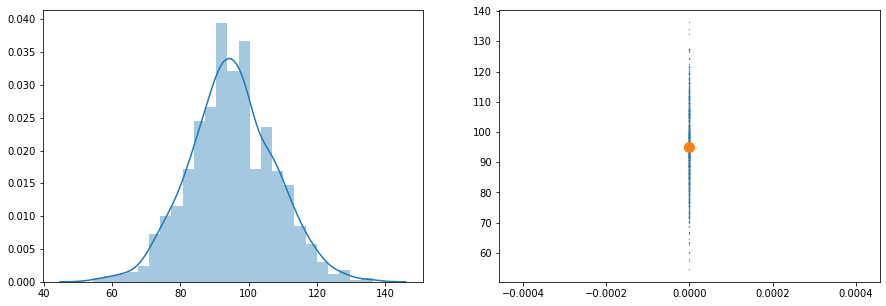

In [17]:
# here we train model on different datasets and calculate expected prediction and it's fluctuation (variance).

N = 1000 # we train model on N different datasets in total.

x0 = 5 # this is our fixed data point on which we will measure prediction quality and fluctuations.

use_first_model=True # boolean flag wheather to use first (simple) model or second (simple) model.

y_preds = []
    
for _ in range(1000):
        
    y_true, y_pred = fit_and_predict(x0, use_first_model=False)
        
    y_preds.append(y_pred)

print('True Value: ', y_true)
print('Average Estimate: ', np.mean(y_pred))
print('Bias: ', y_true - np.mean(y_pred))
print('Variance: ', np.mean((y_preds - np.mean(y_pred))**2))


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(y_preds, ax=ax[0])
ax[1].scatter([0]*len(y_preds), y_preds, s=0.1)
ax[1].scatter([0], [y_true], s=100)

<b><u>Question:</u></b> Which of the above pictures of darts do these two cases relate to?

As we saw from the examples, first (simple) model's prediction on given $x_0$ systematically deviated from it's true value, whereas, complex model's prediction was centered around it's true value. We call this phenomenon model's <b/>bias</b> - measure of deviation from true value. 

Formally, $Bias(\hat{f}(x_0))=f(x_0)-\mathbb{E}[\hat{f}(x_0)]\$, where expectation is over different training sets.

We also can observe, that first (simple) model's predictions where <b>less fluctuating</b> over different training sets as opposed to second (complex) model where fluctuations were higher.

We measure a fluctuations using <b>variance</b>: $Var(\hat{f}(x_0))=\mathbb{E}[(\hat{f}(x_0)-\mathbb{E}[\hat{f}(x)])^2]$

<br />
<br />

<b>Some More Observations...</b>
    
<ul>
    <li><b>Overfitting</b> (case of complex model above) is usually associated with <b>small bias</b> and <b>high variance</b></li>
    <li><b>Underfitting</b> (case of simple model above) is usually associated with <b>high bias</b> and <b>small variance</b></li>
</ul>

<big><b>Important Fact:</b></big>

Usually in Machine Learning (except sometimes in Deep Learning) there is a trade-off between model's Bias and Variance. 

As we gradually grow model's complexity, we gradually reduce bias and increase variance. 

The goal is to find a sweet spot where both bias and variance are acceptable.

<big><b>Theorem (Bias-Variance Decomposition)</b></big>

Whichever model $\hat{f}$ we select, we can decompose its expected error (quadratic risk / mean squared error in practice) on an arbitrary data point $x_0$ as follows:

$\mathbb{E}\Big[\big(f(x_0) - \hat{f}(x_0)\big)^2\Big]
= \Big(\operatorname{Bias}\big[\hat{f}(x_0)\big] \Big) ^2 + \operatorname{Var}\big[\hat{f}(x_0)\big] + \sigma^2$

<br />

where $\sigma^2$ is an <b>irreducible error</b> which we can't get rid off. This error is usually induced by error in observations in our data.

<b>Cross-Validation</b> is usually a good method for estimating expected error of a model.

Estimating expected error is, in some sense, a good way to estimate model's generalization ability.

## Regularization

From previous sections we saw that we need to avoid both underfitting and overfitting. 

Underfitting can be avoiding simply by increasing model compexity, but then it can overfit.

<b>Regularization</b> in Machine Learning is a set of techniques usually involving imposing certain constraints on model's structure to prevent fitting noisy points in data.

This section will cover so called <b>L1 and L2 regularization techniques</b>, which basically involves constraining model weights to grow large. Particularly, we add extra component to loss function, that is, an L1 or L2 norm of the weights.

$NewLoss(\hat{y}, y)=Loss(\hat{y}, y) + \alpha*\| x\|_2^2$ in case of L2 Regularization<br /><br />
$NewLoss(\hat{y}, y)=Loss(\hat{y}, y) + \alpha*| x|$ in case of L1 Regularization

$\alpha$ is <b>hyperparameter</b> controlling the strength of regularization effect.

Linear Regressions with L2 and L1 regularization are called <b>Ridge</b> and <b>Lasso</b> Regressions, respectively.

Loss functions of Ridge and Lasso regressions are still <b>Convex</b> functions and have global optima (proof is beyond this class). 

In [18]:
# importing Ridge and Lasso Regressions from Scikit-Learn

from sklearn.linear_model import Ridge, Lasso

L2 Norm of model weights: 0.41207601270829974

weights:
w0=0.243
w1=0.316
w2=0.395
w3=0.166
w4=0.259
w5=-0.046
w6=0.002


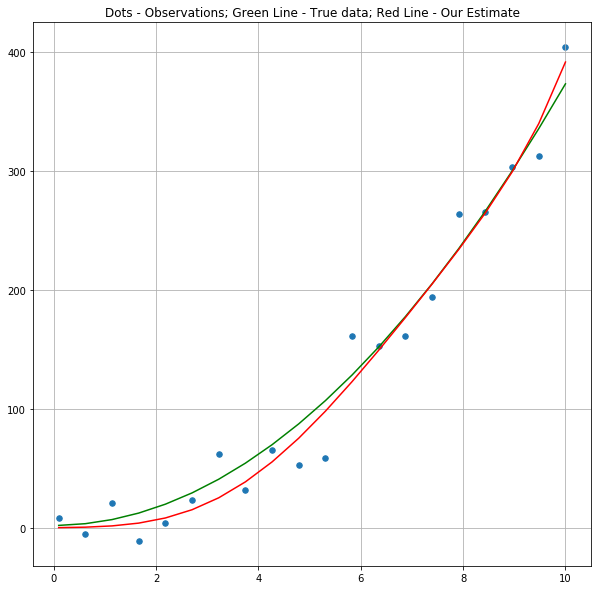

In [22]:
def fit_and_predict(alpha, ridge=True):
    """Same function as used above, just with small modifications.
    
    Here we use polynomial features up to 6-th degree and test Ridge regression with different hyperparameters
    alpha.
    
    We observe how the L2 norm of weights changes with different settings for alpha.
    """

    X, Y_true, e = generate_training_set(A, B, C, size=20, eps=20)

    Y = Y_true + e # creating noisy observations by adding Gaussian noise (this is our train data)
    
    poly = PolynomialFeatures(degree=6, include_bias=True)
    
    # augmenting training data with polynomial features
    X1 = poly.fit_transform(X.reshape(-1, 1))

    if ridge:
        model = Ridge(alpha=alpha, fit_intercept=False) 
    else:
        model = Lasso(alpha=alpha, fit_intercept=False)

    model.fit(X1, Y) # fitting the model using OLS
    print("L2 Norm of model weights:", np.sum(model.coef_**2))
    print('\nweights:')
    print('\n'.join('w%d=%.3f' % (i, w) for i, w in enumerate(model.coef_)))
    
    plt.figure(figsize=(10, 10))
    plt.scatter(X, Y, s=30)
    plt.plot(X, Y_true, 'g')
    plt.plot(X, model.predict(X1), 'r')
    plt.title('Dots - Observations; Green Line - True data; Red Line - Our Estimate')
    plt.grid()    

fit_and_predict(100, ridge=True)
#fit_and_predict(100)

<b>Some Observations...</b>

<ul>
<li>Both types of regularization make weights smaller in magnitude depending on the $\alpha$ hyperparameter.</li>
<li>Lasso Regression introduces <b>sparsity</b> in model weights, which might be useful sometimes.</li>
    <li>Lasso objective is <b>non-differentiable</b> (due to abs() function) and can't be solved in a same way as OLS solution. Scikit-Learn uses iterative coordinate ascent algorithm (details are beyond this class).</li>
</ul>